# Tutorial AverageLearner1D

In [2]:
import adaptive
adaptive.notebook_extension()

# Import modules that are used in multiple cells
import holoviews as hv
import numpy as np
from functools import partial
import random
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

from adaptive.tests import test_average_learner1d as tests
from adaptive.learner.learner1D import (curvature_loss_function,
                                        uniform_loss,
                                        default_loss,
                                        triangle_loss)

%config InlineBackend.figure_formats=set(['svg'])

### Function

First, we define the (noisy) function to be sampled. If one wants to use our plotting tools, the function needs at least two arguments: `x` (non-default argument) and `sigma` (default argument). The first one is the value of the independent variable. `sigma` is a parameter that measures the intensity of the noise, and it should have value $0$ when there is no noise (in our functions, `sigma` is generally the standard deviation of a Gaussian noise).

In [10]:
def my_fun(x, sigma = 0, peak_width = 0.05, offset = -0.5, wait = False):
    from time import sleep
    from random import random
    if wait:
        sleep(random())
        
    fun = x**3 - x + 3*peak_width**2 / (peak_width**2 + (x - offset)**2) 
    return fun + np.random.normal(0,sigma)

bounds = [-2,2]
sigma = 2

<br>
&nbsp;
This is how the function looks like without noise:

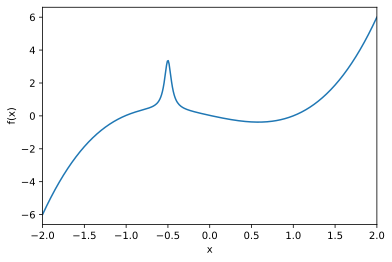

In [11]:
tests.plot_fun(partial(my_fun, sigma = 0), bounds, N = 400)

<br>
&nbsp;
This is how it looks like with noise:

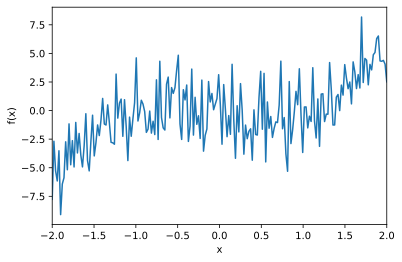

In [12]:
tests.plot_fun(partial(my_fun, sigma = sigma), bounds)

<br>
&nbsp;

### Learner1D

Before going into the AverageLearner1D, let us look at the results of a Learner1D sampling the function without noise. Note that we are using the triangle loss.

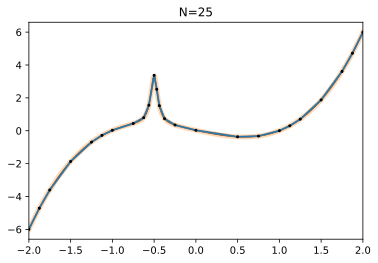

In [13]:
learner1 = adaptive.Learner1D(partial(my_fun, sigma = 0), bounds = bounds, 
                              loss_per_interval=triangle_loss)
tests.run_N(learner1,25)
tests.plot_learner(learner1, Nfun = 200)

<br>
&nbsp;

### AverageLearner1D

The behavior of the AverageLearner1D is governed by several parameters:

 - `loss_per_interval`: loss function (same as in the Learner1D). In our example we use the triangle loss.
<br>
&nbsp;
 - `strategy`: set to 5. Other values are experimental. (We might remove this parameter in the final version).
<br>
&nbsp;
 - `alfa`: the uncertainty of each point ($\Delta g_i$) is estimated as half of the size of the $P\%$ interval of confidence on the estimate of the mean, where $P=(1-2\cdot$ `alfa` $)\cdot100$. The recommended values for `alfa` are $2.5\%-0.05\%$. We generally employ `alfa` $=0.5\%$.
<br>
&nbsp;
 - `delta`: __this parameter is the most relevant and controls the resampling condition__. A point $x_i$ is resampled if $\Delta g_i > $ `delta` $\cdot\min(d_i,d_{i+1})$, where $d_i = \sqrt{(x_{i+1}-x_i)^2 + (y_{i+1}-y_i)^2}$ and $\Delta g_i$ is the uncertainty in the estimate of the mean at $x_i$. Large values of `delta` favor the "exploration" behavior, although this can make the learner to sample noise (in any case, we strongly recommend `delta` $\leq1$).
On the contrary, small values favor an "exploitation" behavior, leading the learner to thoroughly resample existing points. In the documentation, we give bounds for the optimal value of `delta`. In general, the optimal value is around `delta` $\sim 0.1-0.5$, which we will use in our example.
<br>
&nbsp;
 - `min_samples`: minimum number of times that each new point is initially sampled. This parameter is important to prevent the learner from sampling noise in case we accidentally set a too large value of `delta`. However, one must keep in mind that using an excessively large value for `min_samples` can harm the efficiency of the learner. If we estimate that we will require more than a thousand samples per point, we could set `min_samples` $=500$. 
In our example, we are not sure how many samples per point we will need, so we choose a safe value: `min_samples` $=50$.
<br>
&nbsp;
 - `neighbor_sampling`: each new point is actually sampled $n_\text{new}=\max($ `min_samples` , `neighbor_sampling`$\cdot n_\text{neigh})$ times, where $n_\text{neigh}$ is the average number of samples of the two neighboring points. Moreover, we strongly recommend `neighbor_sampling` $\in [0,1]$ to avoid oversampling (values close to 1, e.g. above 0.7, can also lead to oversampling at some points). In this example we use `neighbor_sampling` $=0.5$.
<br>
&nbsp;
 - `max_samples`: maximum number of samples at each point. If a point has been sampled `max_samples` times, it will never be sampled again. In case we set a too small `delta`, this prevents the "exploitation" to drastically dominate over the "exploration" behavior. We will use `max_samples` $=3000$ in our example.
<br>
&nbsp;
 - `min_Delta_g`: minimum uncertainty at each point. If $\Delta g_i<$ `min_Delta_g`, $x_i$ will not be sampled again. This parameter has the same goal as `max_samples`: in case we set a too small `delta`, it prevents the "exploitation" to drastically dominate over the "exploration" behavior. In our example, we do not require any precision beyond $10^{-3}$, so we choose `min_Delta_g` $=10^{-3}$.
 

In [23]:
# Learner parameters
loss_per_interval = triangle_loss
strategy = 5
alfa = 0.005
delta = 0.5
min_samples = 50
max_samples = 3000
min_Delta_g = 0.001
neighbor_sampling = 0.5

# Function
fun = partial(my_fun, sigma = sigma)

# Other parameters
randomseed = 2

## -----------------------------------

# Initialize learner
learner = adaptive.AverageLearner1D(fun,
                                    loss_per_interval=loss_per_interval,
                                    strategy = strategy, bounds=bounds,
                                    alfa=alfa, delta=delta, 
                                    min_samples=min_samples, 
                                    max_samples=max_samples,
                                    min_Delta_g=min_Delta_g,
                                    neighbor_sampling=neighbor_sampling)

<br>
&nbsp;

Next, we run the learner for $N=15000$ samples ($n$ is the total number of points):

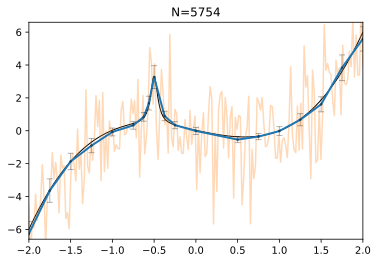

In [24]:
# Set random seed
random.seed(randomseed)
np.random.seed(randomseed)

# Run and plot in real-time
tests.simple_liveplot(learner, N_batch = 500, goal = lambda l: l.total_samples()>=15000)

# Alternative goal using the number of points n
#tests.simple_liveplot(learner, N_batch = 500, goal = lambda l: len(l.data)>=25)

<br>
&nbsp;

### Running in parallel

The AverageLearner1D can also be run in parallel for computational speed-up. The way to do this is the same as with the Learner1D. 

Note that we use the AverageLearner1D_parallel, which is the parallelized version of the AverageLearner1D. We kept both types of learner since they were being tested simultaneously. In the final version, AverageLearner1D_parallel will become the only AverageLearner1D.

In [25]:
# Initialize learner
learner = adaptive.AverageLearner1D_parallel(fun,
                                             loss_per_interval=loss_per_interval,
                                             bounds=bounds,
                                             alfa=alfa, delta=delta, 
                                             min_samples=min_samples, 
                                             max_samples=max_samples,
                                             min_Delta_g=min_Delta_g,
                                             neighbor_sampling=neighbor_sampling)

# Set random seed
random.seed(randomseed)
np.random.seed(randomseed)

# Run IN PARALLEL
runner = adaptive.Runner(learner, goal = lambda l: l.total_samples>=15000)
runner.live_info()
runner.live_plot(update_interval=0.1)

Button(description='cancel live-plot', layout=Layout(width='150px'), style=ButtonStyle())

:DynamicMap   []
   :Overlay
      .Scatter.I   :Scatter   [x]   (y)
      .ErrorBars.I :ErrorBars   [x]   (y,yerror)
      .Path.I      :Path   [x,y]

<br>
&nbsp;
<br>
&nbsp;
<br>
&nbsp;